<h1>Installing the dependencies first<h1>

In [1]:
!pip install datasets==1.3.0
!pip install transformers==4.3.2
!pip install folium==0.2.1
!pip install imgaug==0.2.6
!pip install numpy==1.19.2

<h2>Load dataset</h2>

In [2]:
from datasets import load_dataset
emotions_dataset = load_dataset('go_emotions', 'simplified')

Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e)


To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [3]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [4]:
# For simplicity, train model with single label for item.
restricted_dataset = emotions_dataset.filter(lambda x: len(x["labels"]) == 1 and 27 not in x['labels'])
print(len(restricted_dataset['train']))
show_random_elements(restricted_dataset['train'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-795a7dd4fa0a41dd.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-888342e8a6370469.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-dda5155187038717.arrow


23485


,id,labels,text
0,edjxoh9,[0],I shave it. Btw great way to cheer me up saying I look like I'm 45 at 23
1,ed17nps,[6],Is that listing not supposed to be a joke?
2,eeymht7,[0],He's been great since his first snap as a [NAME]
3,edkqhj1,[17],I always thought of the sound of lakes freezing on cold nights. It's pretty surreal in itself.
4,eewq7jc,[17],Oh the joys of Marine Corps boot camp!!
5,ee3ooph,[17],Imagine making a homophobic joke when your name is /u/Lebronlover23 OOF.
6,ed33k6t,[8],Would love for us to go to [NAME] and give them Tammy for peanuts with a buyback
7,efbntjz,[13],Can't wait to move out of the city so I can get a gun. No gun city living sucks
8,ed4zr3n,[18],I love you for making this
9,ee3e3o8,[13],"Wow, way to disregard history completely."



The emotions are provided as numeric labels. These are the actual orderings, beginning at 0 for admiration:

In [5]:
labels = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", 
          "confusion", "curiosity", "desire", "disappointment", "disapproval",
          "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
          "joy", "love", "nervousness", "optimism", "pride", "realization",
          "relief", "remorse", "sadness", "surprise", "neutral"]
index_to_labels = {index: label for index, label in enumerate(labels)}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

<h1>Method to define and preprocess the model</h1>

In [6]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

def load_model(name):
  global model
  global tokenizer

  model_name = name
  config = AutoConfig.from_pretrained(model_name, num_labels=27)
  model = AutoModelForSequenceClassification.from_config(config=config)
  tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
  encode_dataset()

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

def convert_labels_to_int(example):
    example['labels'] = example['labels'][0]
    return example

def encode_dataset():
  global encoded_dataset
  encoded_dataset = restricted_dataset.map(preprocess_function, batched=True)
  encoded_dataset = encoded_dataset.map(convert_labels_to_int)

## Fine-tuning the model

In [7]:
metric = datasets.load_metric('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return metric.compute(predictions = predictions, references = labels)

<hr>
<hr>
<hr>

<h1>Qs 1. Can you report how accuracy changes with varying the hypyerparameters defined above? How does accuracy change with increasing number of epochs? Learning rate? Mention your final choice of parameters and graph how they impact accuracy.</h1>

<p>We first define the combinations of hypyerparameters that we will be using for our evaluations</p>

Let us evaluate the model on <b>number of epoches</b> and <b>learning rate</b> as asked for.
</br>
<b>number of epochs</b> : 1, 2, 3 and 4
</br>
<b>learning rate</b> : 2e-6, 2e-5 and 2e-4

</br>
So, We will use all the possoble combitions of the above parameters as described in the below table :
</br>
<table>
<tr>
<th>no of epoches</th>
<th>learning rate</th>
</tr>
<tr>
<td>1</td>
<td>2e-06</td>
</tr>
<tr>
<td>1</td>
<td>2e-05</td>
</tr>
<tr>
<td>1</td>
<td>0.0002</td>
</tr>
<tr>
<td>2</td>
<td>2e-06</td>
</tr>
<tr>
<td>2</td>
<td>2e-05</td>
</tr>
<tr>
<td>2</td>
<td>0.0002</td>
</tr>
<tr>
<td>3</td>
<td>2e-06</td>
</tr>
<tr>
<td>3</td>
<td>2e-05</td>
</tr>
<tr>
<td>3</td>
<td>0.0002</td>
</tr>
<tr>
<td>4</td>
<td>2e-06</td>
</tr>
<tr>
<td>4</td>
<td>2e-05</td>
</tr>
<tr>
<td>4</td>
<td>0.0002</td>
</tr>
</table>

Let us describe the above parameters as arrays and generate the possible combinations

In [8]:
def getCombinations(epoch_sizes, learning_rates):
  combinations = []
  for i in range(len(epoch_sizes)):
    for j in range(len(learning_rates)):
      combination = {'epoch_size' : epoch_sizes[i],
                     'learning_rate' : learning_rates[j]}
      combinations.append(combination)
  return combinations

#Lets increase number of epoches with a steady rate
epoch_sizes = [1, 2, 3, 4]
#Lets increase learning rate uniformly by a factor of x10
learning_rates = [2e-6, 2e-5, 2e-4]

combinations = getCombinations(epoch_sizes, learning_rates)

#Set print_as_html to print the combinations as html
print_as_html = False
for c in combinations:
  if(not print_as_html):
    print(c)
  else:
    print('<tr>')
    for k in c:
      print(f'<td>{c[k]}</td>')
    print('</tr>')

{'epoch_size': 1, 'learning_rate': 2e-06}
{'epoch_size': 1, 'learning_rate': 2e-05}
{'epoch_size': 1, 'learning_rate': 0.0002}
{'epoch_size': 2, 'learning_rate': 2e-06}
{'epoch_size': 2, 'learning_rate': 2e-05}
{'epoch_size': 2, 'learning_rate': 0.0002}
{'epoch_size': 3, 'learning_rate': 2e-06}
{'epoch_size': 3, 'learning_rate': 2e-05}
{'epoch_size': 3, 'learning_rate': 0.0002}
{'epoch_size': 4, 'learning_rate': 2e-06}
{'epoch_size': 4, 'learning_rate': 2e-05}
{'epoch_size': 4, 'learning_rate': 0.0002}


Now lets describe the model genearator function

In [9]:
import numpy as np
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

def runModel(epoch_size, learning_rate):
  print(f'Training model for epoch_size : {epoch_size} and learning_rate : {learning_rate}')
  metric_name = "accuracy"

  args = TrainingArguments(
      "test-emotions",
      evaluation_strategy = "epoch",
      learning_rate = learning_rate,
      per_device_train_batch_size = 32,
      per_device_eval_batch_size = 32,
      num_train_epochs = epoch_size,
      weight_decay = 0.01,
      #We should set load_best_model_at_end to False as we want to deterine the effect of batch sizes
      #So if accuracy decrease after certain batches, it will still give the best model that will
      #not fulfill our purpose
      load_best_model_at_end = False,
      metric_for_best_model = metric_name)

  validation_key = "validation"

  trainer = Trainer(
      model,
      args,
      train_dataset = encoded_dataset["train"],
      eval_dataset = encoded_dataset["validation"],
      tokenizer = tokenizer,
      compute_metrics = compute_metrics)

  trainer.train()
  res = trainer.evaluate()
  return res

<h1>Pre Saved results<h1>
<p>These results were saved when the complete combinations were evaluated, and are hard codded here now so if we desire to use them again we can use them, altough if we rerun all the combinations the variable will be overwritten later in the code</p>

In [10]:
saved_results = [{'epoch_size': 1, 'learning_rate': 2e-06, 'eval_loss': 2.9802091121673584, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 1.7851, 'eval_samples_per_second': 1655.969, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 2e-05, 'eval_loss': 2.0992298126220703, 'eval_accuracy': 0.4313261163734777, 'eval_runtime': 1.7863, 'eval_samples_per_second': 1654.853, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 0.0002, 'eval_loss': 1.7256498336791992, 'eval_accuracy': 0.5223274695534507, 'eval_runtime': 1.7851, 'eval_samples_per_second': 1655.909, 'epoch': 1.0}, {'epoch_size': 2, 'learning_rate': 2e-06, 'eval_loss': 1.7033883333206177, 'eval_accuracy': 0.5196211096075778, 'eval_runtime': 1.7876, 'eval_samples_per_second': 1653.628, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 2e-05, 'eval_loss': 1.6181644201278687, 'eval_accuracy': 0.5524357239512855, 'eval_runtime': 1.7906, 'eval_samples_per_second': 1650.845, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 0.0002, 'eval_loss': 1.569570541381836, 'eval_accuracy': 0.5720568335588633, 'eval_runtime': 1.7892, 'eval_samples_per_second': 1652.168, 'epoch': 2.0}, {'epoch_size': 3, 'learning_rate': 2e-06, 'eval_loss': 1.6316291093826294, 'eval_accuracy': 0.5679972936400541, 'eval_runtime': 1.795, 'eval_samples_per_second': 1646.751, 'epoch': 3.0}, {'epoch_size': 3, 'learning_rate': 2e-05, 'eval_loss': 1.8253920078277588, 'eval_accuracy': 0.553788903924222, 'eval_runtime': 1.7875, 'eval_samples_per_second': 1653.723, 'epoch': 3.0}, {'epoch_size': 3, 'learning_rate': 0.0002, 'eval_loss': 2.0674209594726562, 'eval_accuracy': 0.547361299052774, 'eval_runtime': 1.7896, 'eval_samples_per_second': 1651.722, 'epoch': 3.0}, {'epoch_size': 4, 'learning_rate': 2e-06, 'eval_loss': 2.2355353832244873, 'eval_accuracy': 0.5483761840324763, 'eval_runtime': 1.791, 'eval_samples_per_second': 1650.483, 'epoch': 4.0}, {'epoch_size': 4, 'learning_rate': 2e-05, 'eval_loss': 2.7451794147491455, 'eval_accuracy': 0.5389039242219216, 'eval_runtime': 1.7894, 'eval_samples_per_second': 1651.929, 'epoch': 4.0}, {'epoch_size': 4, 'learning_rate': 0.0002, 'eval_loss': 2.8472988605499268, 'eval_accuracy': 0.5382273342354533, 'eval_runtime': 1.7876, 'eval_samples_per_second': 1653.645, 'epoch': 4.0}]

<h1>Run Models and get result<h1>
<p>Now we defines a function to actually run the above combinations, but as model training is complete once and saved in saved_results varibale above so mode sould be explicitly send as 0 for the training to be again caried out.</p>


In [11]:
def RunModel(mode = -1):
  #Run all combinations from scratch
  if(mode == 0):
    #We will ierate over the combinations and get the result of model
    for i in range(len(combinations)):
      c = combinations[i]
      res = runModel(c["epoch_size"], c["learning_rate"])
      c.update(res)
      print(f'Result of training : {c}')
      print("-----------------------------------------\n-----------------------------------------\n\n")
    print("Complete")

mode = -1

if(mode == 0):
  load_model('distilbert-base-uncased')
  RunModel(mode)
else:
  print("No new training done, will use the already saved result")

No new training done, will use the already saved result


In [12]:
#The new result get saved in the combination dictionary,
#if the code was ran with mode = 0, i.e to do training, the saved_results should be overwrite by combination 
if(mode == 0):
  saved_results = combinations

print(saved_results)

[{'epoch_size': 1, 'learning_rate': 2e-06, 'eval_loss': 2.9802091121673584, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 1.7851, 'eval_samples_per_second': 1655.969, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 2e-05, 'eval_loss': 2.0992298126220703, 'eval_accuracy': 0.4313261163734777, 'eval_runtime': 1.7863, 'eval_samples_per_second': 1654.853, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 0.0002, 'eval_loss': 1.7256498336791992, 'eval_accuracy': 0.5223274695534507, 'eval_runtime': 1.7851, 'eval_samples_per_second': 1655.909, 'epoch': 1.0}, {'epoch_size': 2, 'learning_rate': 2e-06, 'eval_loss': 1.7033883333206177, 'eval_accuracy': 0.5196211096075778, 'eval_runtime': 1.7876, 'eval_samples_per_second': 1653.628, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 2e-05, 'eval_loss': 1.6181644201278687, 'eval_accuracy': 0.5524357239512855, 'eval_runtime': 1.7906, 'eval_samples_per_second': 1650.845, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 0.0002, 'eval_loss': 1

<h1>Dependence of accuracy upon Epoch Size</h1>
<p>Lets discuss the accuraacy upon eppoch size first, for this we will keep the learning rate constant and only jugde the accuracy via eppoch size</p>

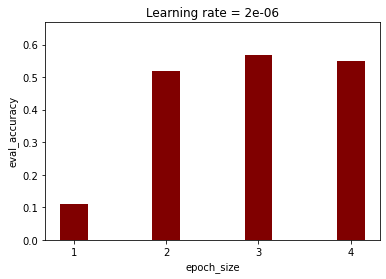

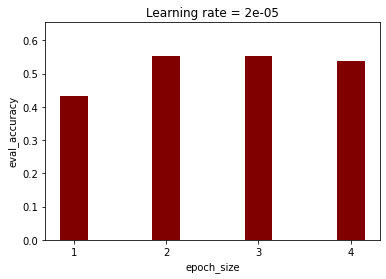

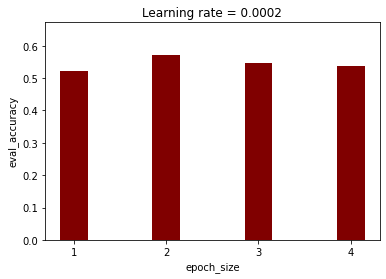

In [13]:
import numpy as np
import matplotlib.pyplot as plt 

learning_rates = list(set([l['learning_rate'] for l in saved_results]))
learning_rates.sort()

for learning_rate in learning_rates:
  epoch_result = [l for l in saved_results if l['learning_rate'] == learning_rate]

  epoch_size = [s['epoch_size'] for s in epoch_result]
  eval_accuracy =  [s['eval_accuracy'] for s in epoch_result]

  plt.bar([str(x) for x in epoch_size], eval_accuracy, color='maroon', width = 0.3)

  plt.ylim(0, max(eval_accuracy)+0.1)
  plt.title(f'Learning rate = {learning_rate}')
  plt.xlabel("epoch_size")
  plt.ylabel("eval_accuracy")
  plt.show()

<h2 style='color:blue'>We can see that accuracy increases when we move from epoch size 1 to 2, but decreases as we move from 3 to 4, and has highest values on 2 and 3, but two out of three times its high on 2, so we select 2 as out epoch size.</h2>

<h1>Dependence of accuracy upon Learning Rate</h1>
<p>Lets discuss the accuraacy upon learning rate, now we will keep the epoch size constant and only jugde the accuracy via learning rate</p>

[1, 2, 3, 4]


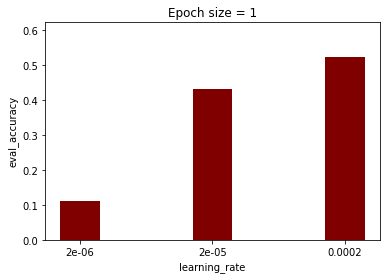

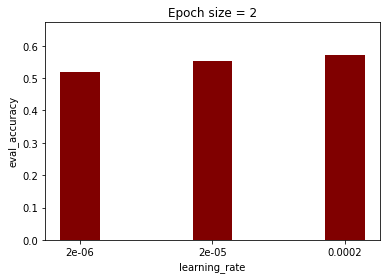

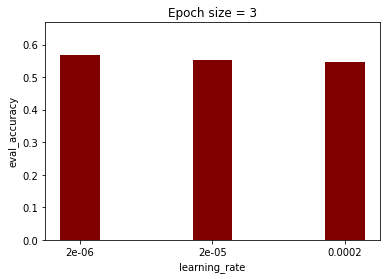

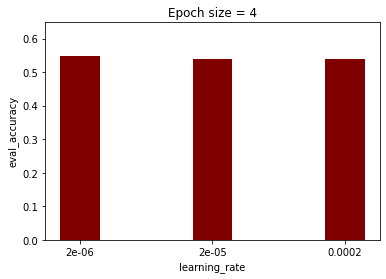

In [14]:
import numpy as np
import matplotlib.pyplot as plt 

epoch_sizes = list(set([l['epoch_size'] for l in saved_results]))
epoch_sizes.sort()
print(epoch_sizes)

for epoch_size in epoch_sizes:
  learning_result = [l for l in saved_results if l['epoch_size'] == epoch_size]

  learning_rate = [s['learning_rate'] for s in learning_result]
  eval_accuracy =  [s['eval_accuracy'] for s in learning_result]

  plt.bar([str(x) for x in learning_rate], eval_accuracy, color ='maroon', width = 0.3)

  plt.ylim(0, max(eval_accuracy)+0.1)
  plt.title(f'Epoch size = {epoch_size}')
  plt.xlabel("learning_rate")
  plt.ylabel("eval_accuracy")
  plt.show()

<h2>We can see rhat accuracy increases as we increase the learning rate, but decreases on large number of eppochs for higher learning rate, but still the decrease is much lesser then the increase in accuracy, so we choose the highest value of learning rate 2e-4 as our final learning rate.</h2>
</br>

<h1>So our choosen values are <b>2 for epoch size</b> and <b>2e-4 for learning rate</b>, lets see where it stands in all results, It is almost the highest!</h1>

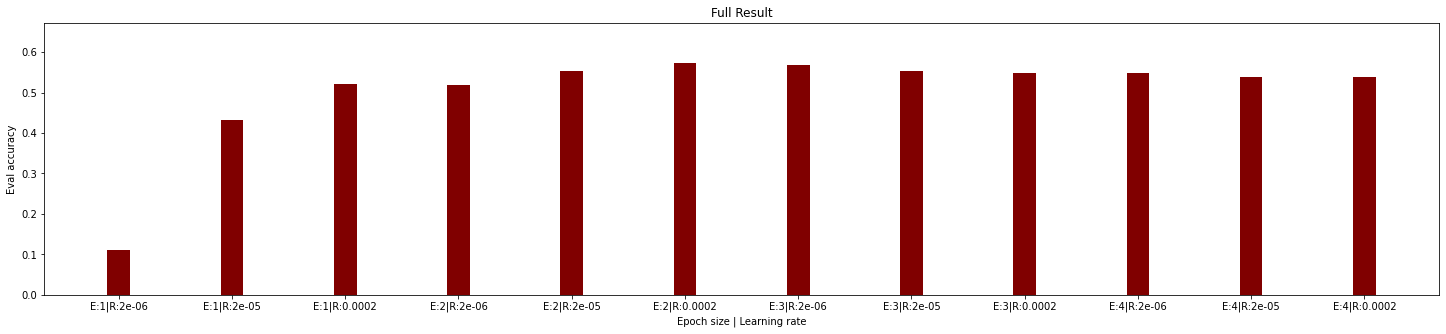

In [15]:
import numpy as np
import matplotlib.pyplot as plt 

pair = [f'E:{s["epoch_size"]}|R:{s["learning_rate"]}' for s in saved_results]
eval_accuracy =  [s['eval_accuracy'] for s in saved_results]

fig = plt.figure(figsize = (25, 5))
plt.bar(pair, eval_accuracy, color ='maroon', width = 0.2)

plt.ylim(0, max(eval_accuracy)+0.1)
plt.title("Full Result")
plt.xlabel("Epoch size | Learning rate")
plt.ylabel("Eval accuracy")
plt.show()

<hr>
<hr>
<hr>

<h1>Qs 2. Try any 2 other models for sequence classification supported by Huggingface and repeat Qs 1 for these. You can find a full list of these <a href="https://huggingface.co/transformers/model_doc/auto.html#automodelforsequenceclassification" target="_defaut">here</a>. (For those of you working with text for your project, you may also find several other useful models for Seq2Seq modeling, question answering, etc.)</h1>

<h1>Model 1 : <a href="https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english" target="_default">distilbert-base-uncased-finetuned-sst-2-english</a></h1>

In [16]:
#Results saved from the first run of all combination for this model
saved_results2 = [{'epoch_size': 1, 'learning_rate': 2e-06, 'eval_loss': 2.9799323081970215, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 1.81, 'eval_samples_per_second': 1633.177, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 2e-05, 'eval_loss': 2.1144936084747314, 'eval_accuracy': 0.4225304465493911, 'eval_runtime': 1.815, 'eval_samples_per_second': 1628.682, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 0.0002, 'eval_loss': 1.6660503149032593, 'eval_accuracy': 0.5382273342354533, 'eval_runtime': 1.8106, 'eval_samples_per_second': 1632.636, 'epoch': 1.0}, {'epoch_size': 2, 'learning_rate': 2e-06, 'eval_loss': 1.6360249519348145, 'eval_accuracy': 0.5487144790257105, 'eval_runtime': 1.8153, 'eval_samples_per_second': 1628.418, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 2e-05, 'eval_loss': 1.5771081447601318, 'eval_accuracy': 0.5717185385656293, 'eval_runtime': 1.8064, 'eval_samples_per_second': 1636.416, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 0.0002, 'eval_loss': 1.5714588165283203, 'eval_accuracy': 0.581190798376184, 'eval_runtime': 1.8083, 'eval_samples_per_second': 1634.696, 'epoch': 2.0}, {'epoch_size': 3, 'learning_rate': 2e-06, 'eval_loss': 1.647143840789795, 'eval_accuracy': 0.5767929634641408, 'eval_runtime': 1.8136, 'eval_samples_per_second': 1629.888, 'epoch': 3.0}, {'epoch_size': 3, 'learning_rate': 2e-05, 'eval_loss': 1.8614081144332886, 'eval_accuracy': 0.5622462787550744, 'eval_runtime': 1.8177, 'eval_samples_per_second': 1626.269, 'epoch': 3.0}, {'epoch_size': 3, 'learning_rate': 0.0002, 'eval_loss': 2.1574547290802, 'eval_accuracy': 0.5446549391069012, 'eval_runtime': 1.815, 'eval_samples_per_second': 1628.623, 'epoch': 3.0}, {'epoch_size': 4, 'learning_rate': 2e-06, 'eval_loss': 2.361755132675171, 'eval_accuracy': 0.5433017591339648, 'eval_runtime': 1.8081, 'eval_samples_per_second': 1634.869, 'epoch': 4.0}, {'epoch_size': 4, 'learning_rate': 2e-05, 'eval_loss': 2.977057933807373, 'eval_accuracy': 0.5267253044654939, 'eval_runtime': 1.812, 'eval_samples_per_second': 1631.345, 'epoch': 4.0}, {'epoch_size': 4, 'learning_rate': 0.0002, 'eval_loss': 3.0134096145629883, 'eval_accuracy': 0.5081190798376184, 'eval_runtime': 1.8116, 'eval_samples_per_second': 1631.73, 'epoch': 4.0}]

In [17]:
#Clone combinations so actual list is not manipulated
combinations2 = combinations.copy()

def RunModel(mode = -1):
  #Run all combinations from scratch
  if(mode == 0):
    #We will ierate over the combinations and get the result of model
    for i in range(len(combinations2)):
      c = combinations2[i]
      res = runModel(c["epoch_size"], c["learning_rate"])
      c.update(res)
      print(f'Result of training : {c}')
      print("-----------------------------------------\n-----------------------------------------\n\n")
    print("Complete")

mode2 = -1

if(mode2 == 0):
  load_model('distilbert-base-uncased-finetuned-sst-2-english')
  RunModel(mode2)
else:
  print("No new training done, will use the already saved result")

No new training done, will use the already saved result


In [18]:
#The result also get saved in the combination dictionary,
#if the code was ran with mode = 0, i.e to do training the saved_results are overwrite by combination 
if(mode2 == 0):
  saved_results2 = combinations2

print(saved_results2)

[{'epoch_size': 1, 'learning_rate': 2e-06, 'eval_loss': 2.9799323081970215, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 1.81, 'eval_samples_per_second': 1633.177, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 2e-05, 'eval_loss': 2.1144936084747314, 'eval_accuracy': 0.4225304465493911, 'eval_runtime': 1.815, 'eval_samples_per_second': 1628.682, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 0.0002, 'eval_loss': 1.6660503149032593, 'eval_accuracy': 0.5382273342354533, 'eval_runtime': 1.8106, 'eval_samples_per_second': 1632.636, 'epoch': 1.0}, {'epoch_size': 2, 'learning_rate': 2e-06, 'eval_loss': 1.6360249519348145, 'eval_accuracy': 0.5487144790257105, 'eval_runtime': 1.8153, 'eval_samples_per_second': 1628.418, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 2e-05, 'eval_loss': 1.5771081447601318, 'eval_accuracy': 0.5717185385656293, 'eval_runtime': 1.8064, 'eval_samples_per_second': 1636.416, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 0.0002, 'eval_loss': 1.57

<h1>Dependence of accuracy upon Epoch Size</h1>
<p>Lets discuss the accuraacy upon eppoch size first, for this we will keep the learning rate constant and only jugde the accuracy via eppoch size</p>

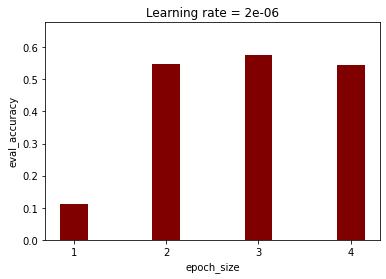

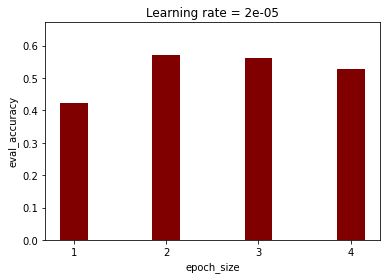

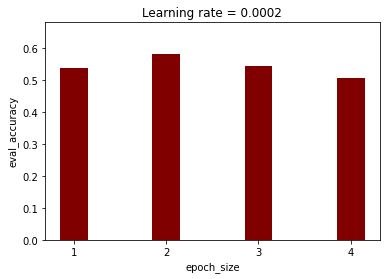

In [19]:
import numpy as np
import matplotlib.pyplot as plt 

learning_rates2 = list(set([l['learning_rate'] for l in saved_results2]))
learning_rates2.sort()

for learning_rate2 in learning_rates2:
  epoch_result2 = [l for l in saved_results2 if l['learning_rate'] == learning_rate2]

  epoch_size2 = [s['epoch_size'] for s in epoch_result2]
  eval_accuracy2 =  [s['eval_accuracy'] for s in epoch_result2]

  plt.bar([str(x) for x in epoch_size2], eval_accuracy2, color='maroon', width = 0.3)

  plt.ylim(0, max(eval_accuracy2)+0.1)
  plt.title(f'Learning rate = {learning_rate2}')
  plt.xlabel("epoch_size")
  plt.ylabel("eval_accuracy")
  plt.show()

<h2 style='color:blue'>We can see here that accuracy increases when we move from epoch size 1 to 2, but decreases as we move from 3 to 4, and has highest values on 2 and 3, but two out of three times its high on 2, so we select 2 as out epoch size.</h2>

<h1>Dependence of accuracy upon Learning Rate</h1>
<p>Lets discuss the accuraacy upon learning rate, now we will keep the epoch size constant and only jugde the accuracy via learning rate</p>

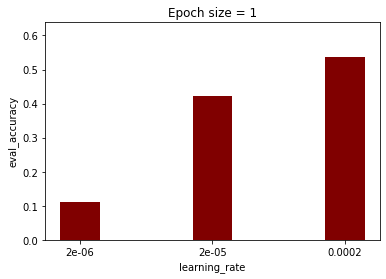

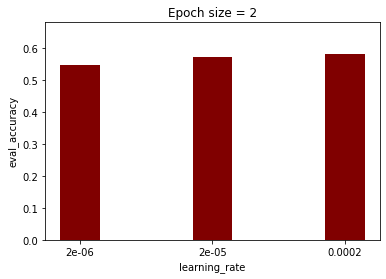

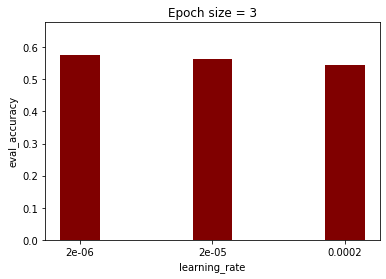

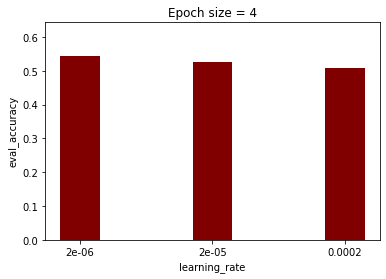

In [20]:
import numpy as np
import matplotlib.pyplot as plt 

epoch_sizes2 = list(set([l['epoch_size'] for l in saved_results2]))
epoch_sizes2.sort()

for epoch_size2 in epoch_sizes2:
  learning_result2 = [l for l in saved_results2 if l['epoch_size'] == epoch_size2]

  learning_rate2 = [s['learning_rate'] for s in learning_result2]
  eval_accuracy2 = [s['eval_accuracy'] for s in learning_result2]

  plt.bar([str(x) for x in learning_rate2], eval_accuracy2, color ='maroon', width = 0.3)

  plt.ylim(0, max(eval_accuracy2)+0.1)
  plt.title(f'Epoch size = {epoch_size2}')
  plt.xlabel("learning_rate")
  plt.ylabel("eval_accuracy")
  plt.show()

<h2>Again, We can see that accuracy increases as we increase the learning rate, but decreases on large number of eppochs for higher learning rate, but still the decrease is much lesser then the increase in accuracy, so we choose the highest value of learning rate 2e-4 as our final learning rate.</h2>
</br>

<h1>So our choice for values: <b>2 for epoch size</b> and <b>2e-4 for learning rate</b> holds still.</h1>

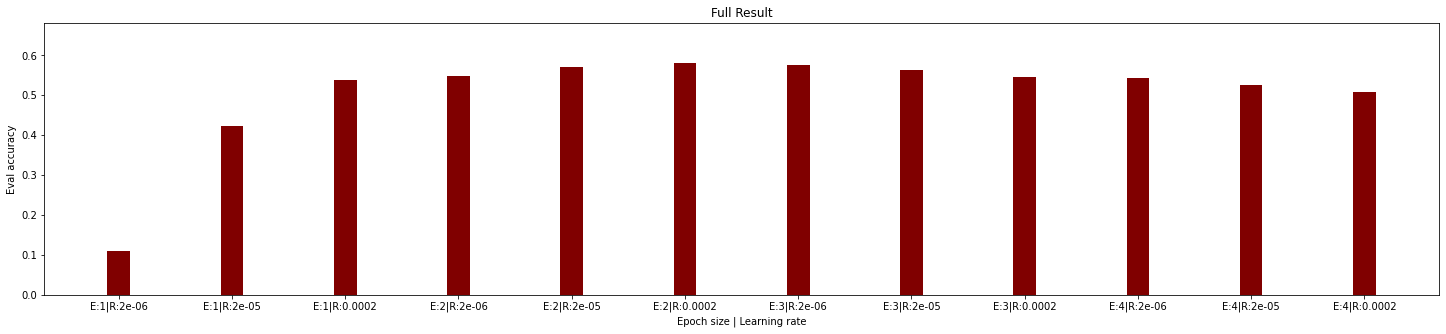

In [21]:
import numpy as np
import matplotlib.pyplot as plt 

pair2 = [f'E:{s["epoch_size"]}|R:{s["learning_rate"]}' for s in saved_results2]
eval_accuracy2 = [s['eval_accuracy'] for s in saved_results2]

fig = plt.figure(figsize = (25, 5))
plt.bar(pair2, eval_accuracy2, color ='maroon', width = 0.2)

plt.ylim(0, max(eval_accuracy2)+0.1)
plt.title("Full Result")
plt.xlabel("Epoch size | Learning rate")
plt.ylabel("Eval accuracy")
plt.show()

<hr>
<hr>
<hr>

<h1>Model 2 : <a href="https://huggingface.co/ProsusAI/finbert" target="_default">ProsusAI/finbert </a></h1>

In [22]:
#Results saved from the first run of all combination for this model
saved_results3 = [{'epoch_size': 1, 'learning_rate': 2e-06, 'eval_loss': 2.9390463829040527, 'eval_accuracy': 0.13227334235453314, 'eval_runtime': 3.505, 'eval_samples_per_second': 843.361, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 2e-05, 'eval_loss': 2.1537256240844727, 'eval_accuracy': 0.40358592692828144, 'eval_runtime': 3.5101, 'eval_samples_per_second': 842.134, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 0.0002, 'eval_loss': 3.0044615268707275, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5036, 'eval_samples_per_second': 843.715, 'epoch': 1.0}, {'epoch_size': 2, 'learning_rate': 2e-06, 'eval_loss': 3.0013301372528076, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5031, 'eval_samples_per_second': 843.825, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 2e-05, 'eval_loss': 3.001232147216797, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5016, 'eval_samples_per_second': 844.187, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 0.0002, 'eval_loss': 3.0031230449676514, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5066, 'eval_samples_per_second': 842.985, 'epoch': 2.0}, {'epoch_size': 3, 'learning_rate': 2e-06, 'eval_loss': 3.0014522075653076, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5074, 'eval_samples_per_second': 842.787, 'epoch': 3.0}, {'epoch_size': 3, 'learning_rate': 2e-05, 'eval_loss': 3.0008232593536377, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5053, 'eval_samples_per_second': 843.294, 'epoch': 3.0}, {'epoch_size': 3, 'learning_rate': 0.0002, 'eval_loss': 3.002368688583374, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5063, 'eval_samples_per_second': 843.057, 'epoch': 3.0}, {'epoch_size': 4, 'learning_rate': 2e-06, 'eval_loss': 3.001242160797119, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5067, 'eval_samples_per_second': 842.964, 'epoch': 4.0}, {'epoch_size': 4, 'learning_rate': 2e-05, 'eval_loss': 3.0015652179718018, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5129, 'eval_samples_per_second': 841.476, 'epoch': 4.0}, {'epoch_size': 4, 'learning_rate': 0.0002, 'eval_loss': 3.0023627281188965, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5049, 'eval_samples_per_second': 843.398, 'epoch': 4.0}]

In [23]:
#Clone combinations so actual list is not manipulated
combinations3 = combinations.copy()

def RunModel(mode = -1):
  #Run all combinations from scratch
  if(mode == 0):
    #We will ierate over the combinations and get the result of model
    for i in range(len(combinations3)):
      c = combinations3[i]
      res = runModel(c["epoch_size"], c["learning_rate"])
      c.update(res)
      print(f'Result of training : {c}')
      print("-----------------------------------------\n-----------------------------------------\n\n")
    print("Complete")

mode3 = -1

if(mode3 == 0):
  load_model('ProsusAI/finbert')
  RunModel(mode3)
else:
  print("No new training done, will use the already saved result")

No new training done, will use the already saved result


In [24]:
#The result also get saved in the combination dictionary,
#if the code was ran with mode = 0, i.e to do training the saved_results are overwrite by combination 
if(mode3 == 0):
  saved_results3 = combinations3

print(saved_results3)

[{'epoch_size': 1, 'learning_rate': 2e-06, 'eval_loss': 2.9390463829040527, 'eval_accuracy': 0.13227334235453314, 'eval_runtime': 3.505, 'eval_samples_per_second': 843.361, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 2e-05, 'eval_loss': 2.1537256240844727, 'eval_accuracy': 0.40358592692828144, 'eval_runtime': 3.5101, 'eval_samples_per_second': 842.134, 'epoch': 1.0}, {'epoch_size': 1, 'learning_rate': 0.0002, 'eval_loss': 3.0044615268707275, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5036, 'eval_samples_per_second': 843.715, 'epoch': 1.0}, {'epoch_size': 2, 'learning_rate': 2e-06, 'eval_loss': 3.0013301372528076, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5031, 'eval_samples_per_second': 843.825, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 2e-05, 'eval_loss': 3.001232147216797, 'eval_accuracy': 0.11028416779431664, 'eval_runtime': 3.5016, 'eval_samples_per_second': 844.187, 'epoch': 2.0}, {'epoch_size': 2, 'learning_rate': 0.0002, 'eval_loss': 3.00

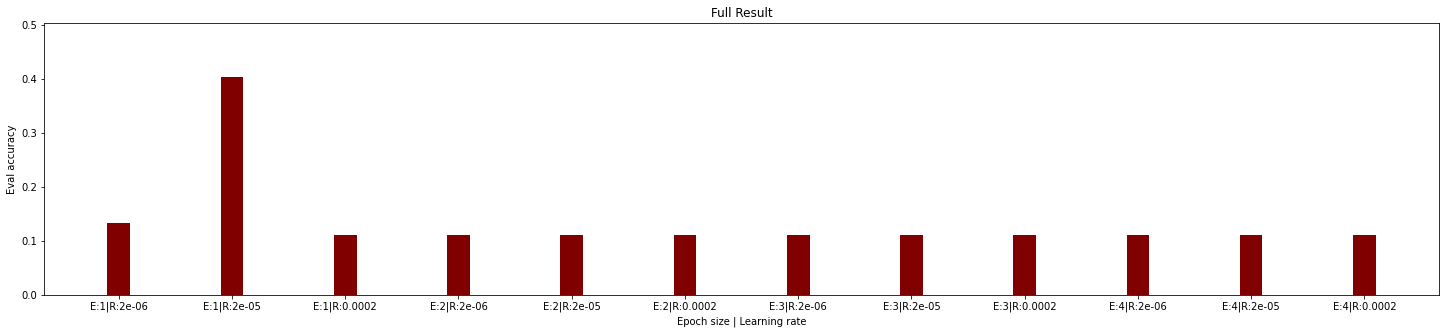

In [25]:
import numpy as np
import matplotlib.pyplot as plt 

pair3 = [f'E:{s["epoch_size"]}|R:{s["learning_rate"]}' for s in saved_results3]
eval_accuracy3 = [s['eval_accuracy'] for s in saved_results3]

fig = plt.figure(figsize = (25, 5))
plt.bar(pair2, eval_accuracy3, color ='maroon', width = 0.2)

plt.ylim(0, max(eval_accuracy3)+0.1)
plt.title("Full Result")
plt.xlabel("Epoch size | Learning rate")
plt.ylabel("Eval accuracy")
plt.show()

<h1>The behaviour of first two steps are identical to previous models, but after that, it appears to be stuck in local minama.</h1>

<hr>
<hr>
<hr>

<h1>Exporting Model</h1>
<p>Here we export the full classses model we do it here as a part of question 4, question 4 also requires to export the model of question 3 which is exported in question 3.</p>

In [30]:
from google.colab import drive
import torch
drive.mount('/content/gdrive')

def export_model():
  load_model('distilbert-base-uncased-finetuned-sst-2-english')
  res = runModel(2, 2e-5)
  print(res)
  model_save_name = 'nlp_model_full.pt'
  path = f'/content/gdrive/My Drive/models/{model_save_name}'
  model.save_pretrained(path)

#Un commint to export full model (again)
#export_model()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-6e5e14bb873f2b3b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-13610349e03cceb3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-e9cd62e6cb5f75ee.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-5248a790bca12dfd.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-61e315394d346724.arrow
Loading cached processed dataset at

Training model for epoch_size : 2 and learning_rate : 2e-05


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.611100,1.896297,0.482409,1.785400,1655.623000
2,1.987000,1.749084,0.519621,1.784000,1656.969000


{'eval_loss': 1.7490838766098022, 'eval_accuracy': 0.5196211096075778, 'eval_runtime': 1.7823, 'eval_samples_per_second': 1658.517, 'epoch': 2.0}


<h1>End 🐍</h1>